In [1]:
## plots
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

In [2]:
import time
import numpy as np
import pandas as pd
import pmdarima as pm
from ast import literal_eval
from matplotlib import pyplot
from datetime import datetime
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import confusion_matrix

In [3]:
from colour import Color
def get_gaivota_palette(gsize):
    c_gaivota = Color("#00358e")
    colors =list(c_gaivota.range_to(Color("#8dca44"),gsize))# gaivota green #8dca44
    colors_gaivota_list=[]
    for c in colors:#[::-1]:
        colors_gaivota_list.append(np.array(c.get_rgb()))
    return sns.color_palette(colors_gaivota_list)

#### Load internal module

In [4]:
from util.metrics import *
from arima.arima_trainer import hyper_param_sarima_trainer, hyper_param_arimax_trainer

## Load Local Market Base

In [5]:
base = pd.read_csv("../data/na_selected_local_market_prices_soybean.csv")
base['Date'] = pd.to_datetime(base['date'])

for name in base['praca_norm'].unique():
    print(name)

Não-Me-Toque/RS
Ubiratã/PR
Londrina/PR
Cascavel/PR
Tangará da Serra/MT
Campo Novo do Parecis/MT
São Gabriel do Oeste/MS
Luís Eduardo Magalhães/BA
Jataí/GO
Porto Paranaguá
Porto Rio Grande
Panambi/RS
Ponta Grossa/PR
Sorriso/MT
Oeste da Bahia
Rio Verde/GO
Castro/PR
Pato Branco/PR
Palma Sola/SC
Rio do Sul/SC
Rondonópolis/MT
Brasília/DF
Alto Garças/MT
Itiquira/MT


## Local Market:

In [6]:
praca_selected = 'Não-Me-Toque/RS'
base_local = base.query('praca_norm == "{}"'.format(praca_selected))
base_local = base_local[['Date','price_sac']]
base_local = base_local.set_index('Date')
base_local = base_local.sort_index(ascending = True)
base_local.head()

,price_sac
Date,
2015-01-02,59.5
2015-01-05,59.5
2015-01-06,60.0
2015-01-07,60.0
2015-01-08,60.0


## Split data

In [7]:
slpit_term = int(len(base_local)*0.85)
train_data, test_data = base_local[:slpit_term], base_local[slpit_term:]

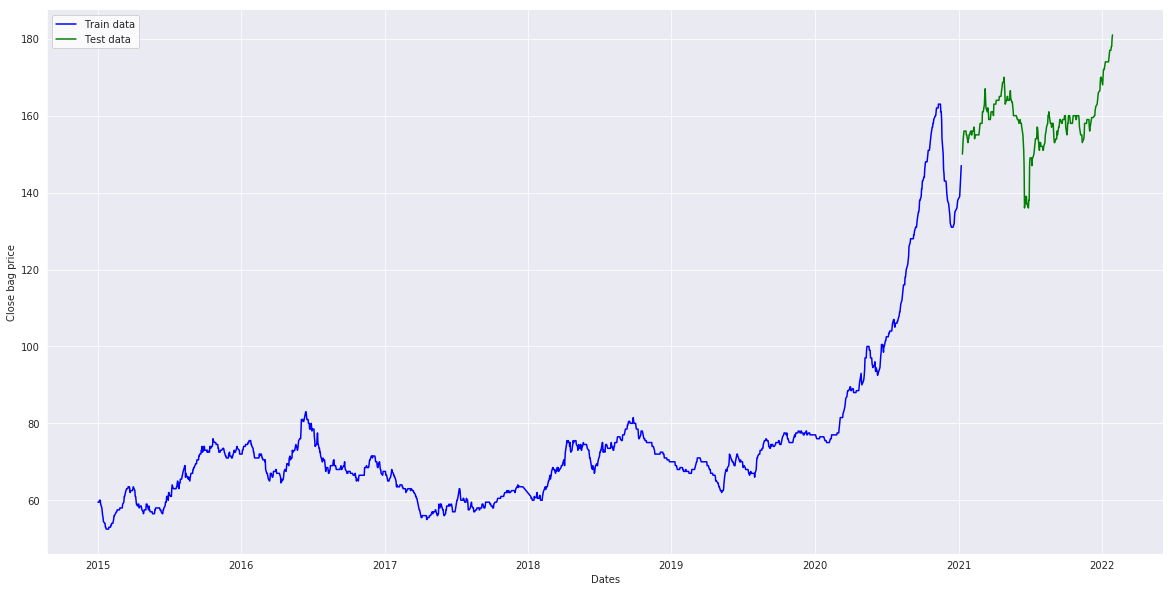

In [8]:
plt.figure(figsize=(20,10))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_data, 'blue', label='Train data')
plt.plot(test_data, 'green', label='Test data')

sns.despine()
sns.set_style(style='white')
plt.ylabel('Close bag price')
plt.legend()
#plt.savefig("data_local_market_sample_divide.png") 

## Checking Seasonal

/home/gaivota/gaivota/work/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  after removing the cwd from sys.path.


<Figure size 432x288 with 0 Axes>

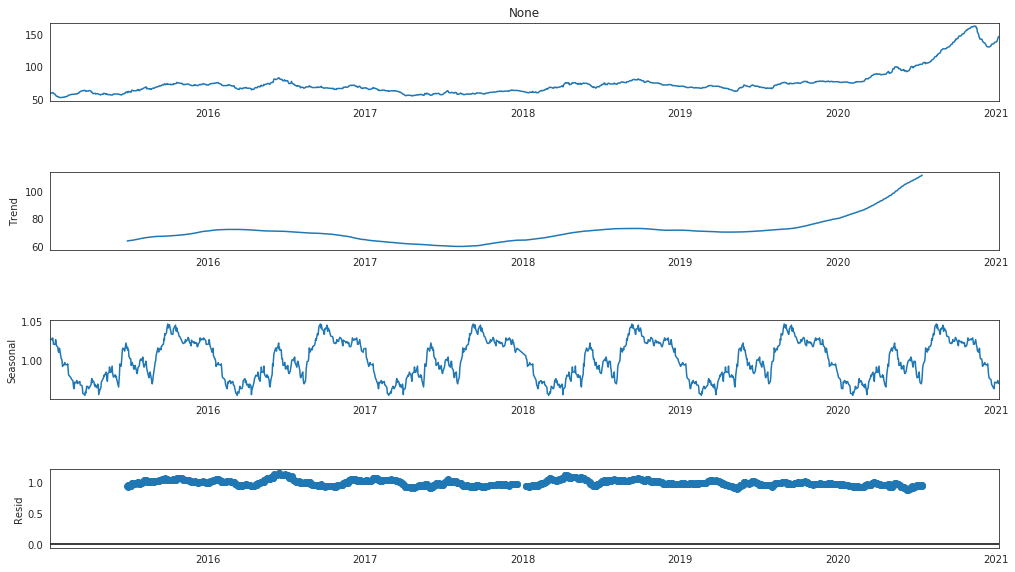

In [9]:
analysis = train_data.copy()
analysis.sort_index(inplace=True)
#253
decompose_result_mult = seasonal_decompose(analysis, model="multiplicative", freq = 241)

trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

fig = plt.figure()  
fig = decompose_result_mult.plot()  
fig.set_size_inches(16, 9)
#fig.savefig("decompose_n_me_toque.png")

In [10]:
d = pm.arima.ndiffs(train_data)

<Figure size 720x720 with 0 Axes>

<Figure size 432x288 with 0 Axes>

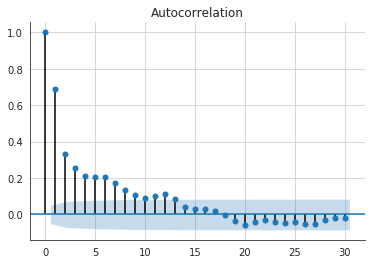

In [11]:
plt.figure(figsize=(10,10))
fig = plt.figure()  
ax = plot_acf(train_data.diff(d).dropna(),lags =30)
plt.grid(True)
sns.despine()
sns.set_style(style='white') 
plt.show()
#ax.savefig("acf_n_me_toque.png")

<Figure size 720x720 with 0 Axes>

<Figure size 432x288 with 0 Axes>

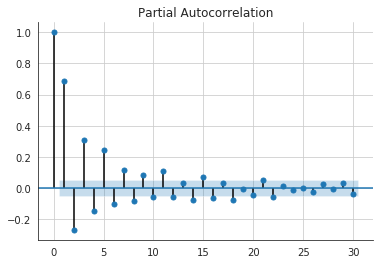

In [12]:
plt.figure(figsize=(10,10))
fig = plt.figure()  
ax = plot_pacf(train_data.diff(d).dropna(), lags = 30)
plt.grid(True)
sns.despine()
sns.set_style(style='white') 
plt.show()
#ax.savefig("pacf_n_me_toque.png")

## Train ARIMA

grid search param

select range for 'p' values (p_values)

select range for 'q' values (q_values)

In [13]:
%%time
model, log_df = hyper_param_arimax_trainer(train_data, p_values = [0,3], q_values = [0,3])

{'order(p,d,q)': '(0, 2, 0)', 'AIC': 3792.9956845135403, 'BIC': 3803.606060944326, 'train_time': 0.16}
{'order(p,d,q)': '(0, 2, 1)', 'AIC': 3139.1832772984794, 'BIC': 3155.0988419446585, 'train_time': 0.15}
25%
{'order(p,d,q)': '(1, 2, 1)', 'AIC': 3125.1887266086155, 'BIC': 3146.4094794701878, 'train_time': 0.27}
{'order(p,d,q)': '(1, 2, 2)', 'AIC': 3085.583522328404, 'BIC': 3112.109463405369, 'train_time': 1.3}
50%
75%
100%
CPU times: user 46.3 s, sys: 22 s, total: 1min 8s
Wall time: 19.4 s


In [14]:
log_df.head()

,AIC,BIC,"order(p,d,q)",train_time
0,3792.995685,3803.606061,"(0, 2, 0)",0.16
1,3139.183277,3155.098842,"(0, 2, 1)",0.15
2,3456.213817,3472.129382,"(1, 2, 0)",0.09
3,3125.188727,3146.409479,"(1, 2, 1)",0.27
4,3127.266331,3148.487084,"(0, 2, 2)",0.35


In [15]:
model.order

(1, 2, 2)

------------------------------

## Evaluation

In [16]:
def build_prediction_series(test_base, model, col = 'price_sac', exo_test_base = pd.DataFrame(), predicts_ahead = 5):
    """
    """
    
    result_predict_series = {}
    is_over = {}
    for x in range(0, predicts_ahead):
        result_predict_series[x + 1] = pd.DataFrame()
        is_over[x + 1] = False
              
    
    for n in range(len(test_base) - 1):
        # update model with today day, (skip day zero, last train date)
        if len(exo_test_base) == 0 and n > 0:
            model.update(test_base.iloc[n][col])
        elif n > 0:
            model.update(test_base.iloc[n][col], exo_test_base[n:n+1])
        
        # next day
        # not exo
        if  len(exo_test_base) == 0:
            pred_1 = pd.DataFrame({'pred_'+col: [model.predict(n_periods = 1)[-1]], 'pred_date':[test_base.index[n+1]]})
            pred_1.index = [test_base.index[n]]
            result_predict_series[1] = result_predict_series[1].append(pred_1)
        # exo variable
        else:
            with warnings.catch_warnings():
                warnings.simplefilter('ignore')
                pred_1 = pd.DataFrame({'pred_'+col: [model.predict(n_periods = 1, exogenous = exo_test_base[n: n + 1])[-1]], 'pred_date':[test_base.index[n+1]]})
            pred_1.index = [test_base.index[n]]
            result_predict_series[1] = result_predict_series[1].append(pred_1)
            
        # Calculate predict ahead 
        for x in range(2,predicts_ahead + 1):
            # no exogenous features
            if len(exo_test_base) == 0:
                if n % x == 0:
                    if n + x <= len(test_base) - 1:
                        pred = pd.DataFrame({'pred_'+col: [model.predict(n_periods = x)[-1]], 'pred_date':[test_base.index[n+x]]})
                        pred.index = [test_base.index[n]]
                    else:
                        if not is_over[x]:
                            pred = pd.DataFrame({'pred_'+col: [model.predict(n_periods = len(test_base) - n)[-1]], 'pred_date':[test_base.index[-1]]})
                            pred.index = [test_base.index[n]]
                            is_over[x] = True
                    if not is_over[x]:
                        result_predict_series[x] = result_predict_series[x].append(pred)
            # with exogenous features
            else:
                if n % x == 0:
                    if n + x <= len(test_base) - 1:
                        with warnings.catch_warnings():
                            warnings.simplefilter('ignore')
                            pred = pd.DataFrame({'pred_'+col: [model.predict(n_periods = x, exogenous = exo_test_base[n: n + x])[-1]], 'pred_date':[test_base.index[n+x]]})
                        pred.index = [test_base.index[n]]
                    else:
                        if not is_over[x]:
                            with warnings.catch_warnings():
                                warnings.simplefilter('ignore')
                                pred = pd.DataFrame({'pred_'+col: [model.predict(n_periods = len(test_base) - n, exogenous = exo_test_base[n:])[-1]],'pred_date':[test_base.index[-1]]})
                            pred.index = [test_base.index[n]]
                            is_over[x] = True
                    if not is_over[x]:
                        result_predict_series[x] = result_predict_series[x].append(pred)
        if n % 50 == 0:
            print(n)
    
    for x in result_predict_series:
        result_predict_series[x]['base_price_sac'] = test_base[test_base.index.isin(result_predict_series[x].index)][col].values
        result_predict_series[x]['original_future_price_sac'] = test_base[test_base.index.isin(result_predict_series[x]['pred_date'])][col].values
    
    return result_predict_series

In [21]:
def build_trend(series_resuls):
    for x in series_resuls:
        series_resuls[x]['original_trend'] =  np.sign(series_resuls[x]['original_future_price_sac'] - series_resuls[x]['base_price_sac'])
        series_resuls[x]['predict_trend'] =   np.sign(series_resuls[x]['pred_price_sac'] - series_resuls[x]['base_price_sac'])
        series_resuls[x]['is_right'] =  series_resuls[x]['original_trend'] == series_resuls[x]['predict_trend']
        series_resuls[x]['absolute_per_error'] = (series_resuls[x]['original_future_price_sac'] - series_resuls[x]['pred_price_sac'])/series_resuls[x]['original_future_price_sac']
        series_resuls[x]['absolute_per_error'] = series_resuls[x]['absolute_per_error'] * 100
    return series_resuls

In [18]:
test_data_eval = test_data.append(train_data[-1:]).sort_index()
serie_result = build_prediction_series(test_data_eval, model, col = 'price_sac')

0
50
100
150
200
250


In [22]:
serie_result_temp =  build_trend(serie_result)

## Check for d+x

#### Curve

In [35]:
# Select d+n
n = 1

/home/gaivota/gaivota/work/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


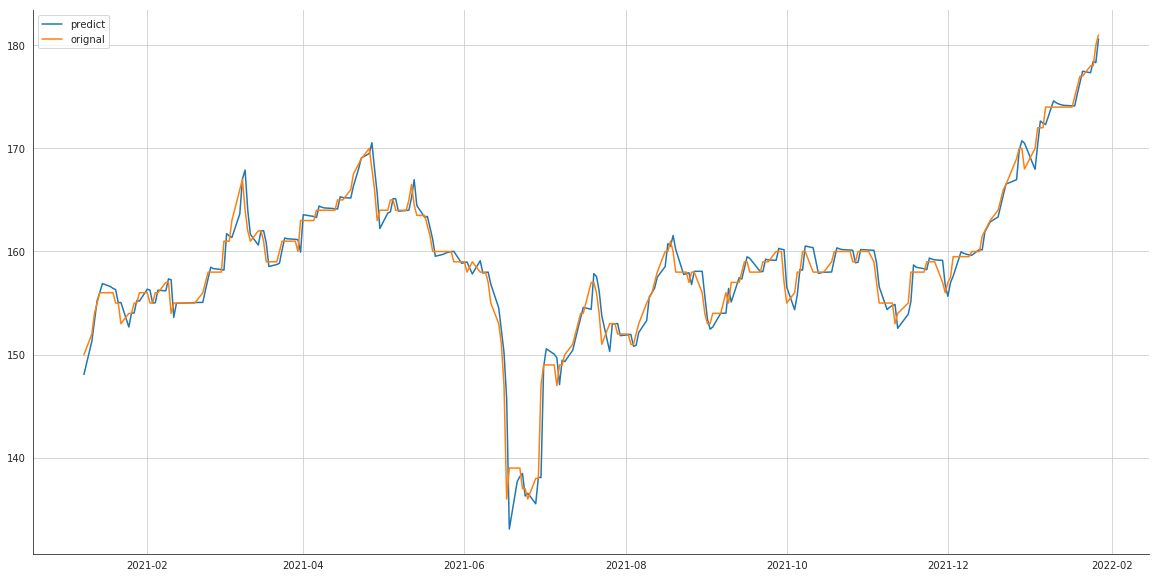

In [36]:
plt.figure(figsize=(20,10))
plt.grid(True)
#plt.plot(test_data, label = 'Test Data')

ax = plt.subplot(111)
plt.plot(serie_result[n]['pred_price_sac'], label = 'predict')
plt.plot(serie_result[n]['original_future_price_sac'], label = 'orignal')
plt.legend()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig = ax.get_figure()
#fig.savefig("result_nao_me_toque.png") 

plt.show()

#### Confusion Matrix

/home/gaivota/gaivota/work/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


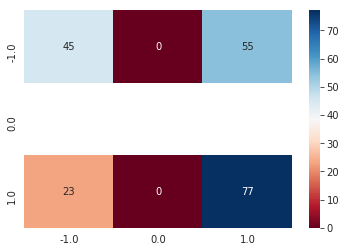

In [37]:
labels_data = list(serie_result[n]['original_trend'].value_counts().sort_index().index)
temp = serie_result[n].query("original_trend != 0")
c = confusion_matrix(temp['original_trend'], temp['predict_trend'], labels = labels_data)
conf_ma = pd.DataFrame(np.round(c/c.astype(np.float).sum(axis=1).reshape(len(labels_data), 1)* 100, 2), columns = labels_data, index = labels_data)
conf_ma['count'] =  c.astype(np.float).sum(axis=1)

cols = list(conf_ma.columns)
cols.remove('count')
sns.heatmap(conf_ma[cols],  annot=True , cmap = 'RdBu')

-------------------------

## ARIMA MODEL TREADMIL

Train best model for each local market, save logs and order in .csv file

In [ ]:
%%time
for praca in base['praca_norm'].unique():
    print("Start Model build for praça: {}".format(praca))
    # Select Praça
    base_local = base.query('praca_norm == "{}"'.format(praca)).copy()
    base_local = base_local[['Date','price_sac']]
    base_local = base_local.set_index('Date')
    base_local = base_local.sort_index(ascending = True)
    
    #Prepare Train/Test base
    slpit_term = int(len(base_local)*0.85)   
    train_data, test_data = base_local[:slpit_term], base_local[slpit_term:]
    
    # Search Best ARIMA model
    print("HYPERPARAM SEARCH")
    row = {}
    row['praça'] = praca
    row['train_size'] =  len(train_data)
    row['test_size'] =  len(test_data)
    model,log = hyper_param_arima_trainer(train_data, p_values = [0,8], q_values = [0,8])
    log = log.sort_values(by = ['AIC','BIC'], ascending = True)
    log.to_csv("../results/arima/{}_arima_train_results.csv".format(praca.replace("/","-")), index = None)
    
    row['order'] = str(model.order)
    aic_order = str(model.order)
    row['loss'] = model.aic()
    row['best_fit_metric'] = ['AIC']
    
    # Test best AIC fit
    print("Metrics for AIC Fit")
    test_data_eval = test_data.append(train_data[-1:]).sort_index()
    serie_result = build_prediction_series(test_data, model, col = 'price_sac')
    serie_result = build_trend(serie_result)
    
    for n in range(1,6):
        row['mape_{}d_pred'.format(n)] = np.round(serie_result[n]['absolute_per_error']/len(serie_result[n]['absolute_per_error']),4)
        row['acc_{}d_pred'.format(n)] =  np.round(serie_result[n].query('original_trend != 0')['is_right'].sum()/len(serie_result[n].query('original_trend != 0')),4)
            
    arima_model_result = arima_model_result.append(row, ignore_index = True)
    # Train best value for BIC
    row = {}
    log = log[log['BIC'] > 0]
    log = log.sort_values(by = ['BIC'], ascending = True)
    order_bic = literal_eval(log['order(p,d,q)'].values[0])
    if aic_order != log['order(p,d,q)'].values[0]:
        
        train_data, test_data = base_local[:slpit_term], base_local[slpit_term:]
        model = pm.arima.ARIMA(order_bic, method='lbfgs', maxiter = 80, suppress_warnings=True, scoring='mse')
        res = model.fit(train_data)
    
        # Test best BIC fit
        print("Metrics for BIT Fit")
        row['praça'] = praca
        row['train_size'] =  len(train_data)
        row['test_size'] =  len(test_data)
    
        row['order'] = str(model.order)
        row['loss'] = model.bic()
        row['best_fit_metric'] = ['BIC']
        
        test_data_eval = test_data.append(train_data[-1:]).sort_index()
        serie_result = build_prediction_series(test_data, model, col = 'price_sac')
        serie_result = build_trend(serie_result)
        
        for n in range(1,6):
            row['mape_{}d_pred'.format(n)] = np.round(serie_result[n]['absolute_per_error']/len(serie_result[n]['absolute_per_error']),4)
            row['acc_{}d_pred'.format(n)] =  np.round(serie_result[n].query('original_trend != 0')['is_right'].sum()/len(serie_result[n].query('original_trend != 0')),4)

        arima_model_result = arima_model_result.append(row, ignore_index = True)
    else:
        print('same bic order')
    arima_model_result.to_csv("../results/arima/arima_praca_results.csv", index = None)